# OCR Models Comparison
This notebook compares the performance of several OCR models on the same dataset.

The OCR models used are:

- PaddleOCR
- TrOCR
- DocTr
- Tesseract

The dataset used to refine the models was collected by the researchers from volunteer individuals who sent their prescriptions and volunteer doctors who created synthetic prescriptions.

## Import and Setup
First, we need to import the necessary libraries and set up the environment.

In [3]:
pip install nltk

nltk.download('words')
nltk.download('brown')

SyntaxError: invalid syntax (3414968473.py, line 1)

In [4]:
pip install wordfreq


Note: you may need to restart the kernel to use updated packages.


In [5]:
import pandas as pd
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from nltk.corpus import words
from wordfreq import zipf_frequency



TEST_IMAGES_DIR = r"C:\Users\Shay\Documents\GitHub\ocr-models\data\image_splits\testing_set_full"

# --- Setup ---
english_words = set(words.words())


Next, let us import the necessary CSV files that contain the images and their corresponding WER and CER values per model.  We will use the `pandas` library to read the CSV files.

In [6]:
# --- Paths to CSVs ---
CSV_PADDLEOCR = "paddleOCR/test_predictions.csv"
CSV_DOCTR = "my_doctr/DocTR_evaluation.csv"
CSV_TESSERACT = "tesseract/Tesseract_test_predictions.csv"
CSV_TROCR = "TrOCR/trocr_evaluation.csv"

# --- Load CSVs ---
df1 = pd.read_csv(CSV_PADDLEOCR)
df2 = pd.read_csv(CSV_DOCTR)
df3 = pd.read_csv(CSV_TESSERACT)
df4 = pd.read_csv(CSV_TROCR)


> We will rename the columns in the data frames to be able to merge all the models together. The data frames will be merged together on the column "image". The columns concerned with CER, WER, and the model's prediction will be kept in the dataframe.

In [7]:
# --- Rename prediction columns ---
df1 = df1.rename(columns={"pred": "pred_paddle"})
df2 = df2.rename(columns={"pred": "pred_doc"})
df3 = df3.rename(columns={"pred": "pred_tess"})
df4 = df4.rename(columns={"pred": "pred_trocr"})

# --- Use only ground truths from docTR CSV ---
df2 = df2.rename(columns={"gt": "gt_doc"})

# --- Rename cer and wer columns ---
df1 = df1.rename(columns={"cer": "cer_paddle", "wer": "wer_paddle"})
df2 = df2.rename(columns={"cer": "cer_doc", "wer": "wer_doc"})
df3 = df3.rename(columns={"cer": "cer_tess", "wer": "wer_tess"})
df4 = df4.rename(columns={"cer": "cer_trocr", "wer": "wer_trocr"})

# --- Merge ---
df_merged = pd.merge(df1, df2, on="image", how="inner")
df_merged = pd.merge(df_merged, df3, on="image", how="inner")
df_merged = pd.merge(df_merged, df4, on="image", how="inner")

# --- Keep only important columns ---
important_cols = [
    "image", "gt_doc",
    "pred_paddle", "pred_doc", "pred_tess", "pred_trocr",
    "cer_paddle", "wer_paddle",
    "cer_doc", "wer_doc",
    "cer_tess", "wer_tess",
    "cer_trocr", "wer_trocr"
]

df_merged = df_merged[important_cols]

In [145]:
# --- Check result ---
print(df_merged.head())
print("Columns:", df_merged.columns.tolist())

         image                                             gt_doc  \
0   data_3.png  Rx Amlodipine 5mg (Provasc) #100 S: 1 tablet o...   
1  data_13.png  1. Vitamin B Complex (PHAREX) #200 170 S: 1 ta...   
2  data_22.png  NAPHAZOLINE #2 PHENIRAMINE MALEATE (VISTALLERG...   
3  data_29.png  Amlodpipine 5mg (Bezam / Provasc) S: 1 tablet ...   
4  data_51.png  TRIAMCINOLONE Acetonide #4 Sig: Apply lotion t...   

                                         pred_paddle  \
0  ennD- Pnormc) #100 acea8 Ithhel 140 uns mutgon...   
1  O A 170 0y S 3re .8 4 ( W TH mnmoom Buf0 D Du2...   
2  TIT VOCINE HENRANE MAEATE V157mERa gedi &x a d...   
3  cuuls dgune gomn (Bezanil Prorozc) #100 day ta...   
4  TRIAMCINOLONE ACtonide AA Lig Apply lotion to ...   

                                            pred_doc  \
0  Rx Ammldodian 5m0 (: Porrvacc #1 1000 S: 1 #al...   
1  2 c.MAASs #0m RX (A Sx A 10m a 200 170 8: 5 AA...   
2  - #2 mit 4t oatc #i ottttprneee #orcaacc (olom...   
3  Aunl aefore 5o0 (Reza

## WER and CER Evaluation

> We extract the Word-Error-Rate (WER) and Character-Error-Rate (CER) for each model from the CSV files.

In [8]:
models = [
    ("PaddleOCR", "pred_paddle", "cer_paddle", "wer_paddle"),
    ("DocTR",     "pred_doc",    "cer_doc",    "wer_doc"),
    ("Tesseract", "pred_tess",   "cer_tess",   "wer_tess"),
    ("TrOCR", "pred_trocr", "cer_trocr", "wer_trocr")
]

summary_rows = []

for model_name, pred_col, cer_col, wer_col in models:
    
    avg_wer = df_merged[wer_col].mean()
    avg_cer = df_merged[cer_col].mean()
    exact_match = (df_merged["gt_doc"] == df_merged[pred_col]).mean()

    summary_rows.append({
        "model": model_name,
        "avg_WER": avg_wer,
        "avg_CER": avg_cer,
        "exact_match_rate": exact_match
    })

summary_df = pd.DataFrame(summary_rows)
summary_df


,model,avg_WER,avg_CER,exact_match_rate
0,PaddleOCR,0.881037,0.555187,0.0
1,DocTR,1.149279,0.688074,0.0
2,Tesseract,0.861517,0.653932,0.0
3,TrOCR,0.867112,0.670224,0.0


> In terms of WER, the tesseract model and TrOCR model were better than the others overall. On the other hand for CER, PaddleOCR was better than the others. We can see that DocTR was the worst performing model overall. To better visualize this data, we can use a box plot.

In [9]:
df_wer = df_merged.melt(
    id_vars=['image'],
    value_vars=['wer_paddle','wer_doc','wer_tess','wer_trocr'],
    var_name='model',
    value_name='WER'
)

df_wer['model'] = df_wer['model'].replace({
    'wer_paddle': 'PaddleOCR',
    'wer_doc': 'DocTR',
    'wer_tess': 'Tesseract',
    'wer_trocr': 'TrOCR'
})


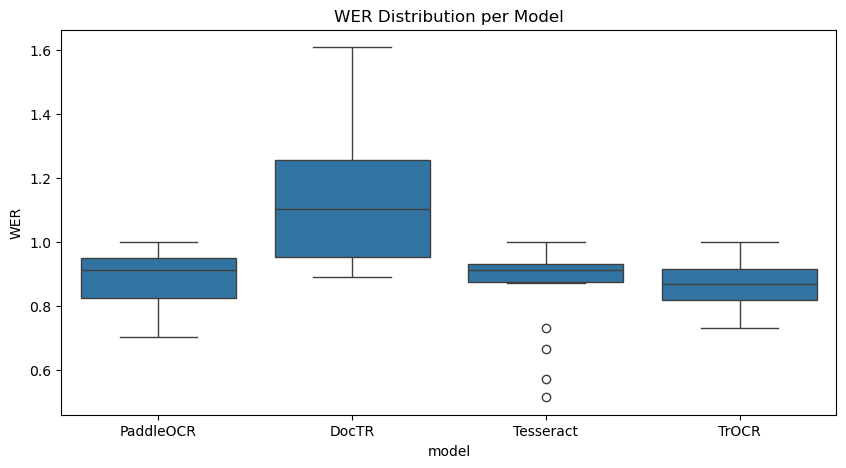

In [10]:
plt.figure(figsize=(10,5))
sns.boxplot(data=df_wer, x='model', y='WER')
plt.title("WER Distribution per Model")
plt.show()

> From what we can see, Tesseract seems to be the most consistent model in terms of Word-Error-Rate (WER). We can see that the IQR lines of Tesseract's box plot are the smallest, which means that the model's predictions are most consistent. PaddleOCR and TrOCR are the next best models with miniscule differences between them.

In [11]:
df_cer = df_merged.melt(
    id_vars=['image'],
    value_vars=['cer_paddle','cer_doc','cer_tess','cer_trocr'],
    var_name='model',
    value_name='CER'
)

df_cer['model'] = df_cer['model'].replace({
    'cer_paddle': 'PaddleOCR',
    'cer_doc': 'DocTR',
    'cer_tess': 'Tesseract',
    'cer_trocr': 'TrOCR'
})

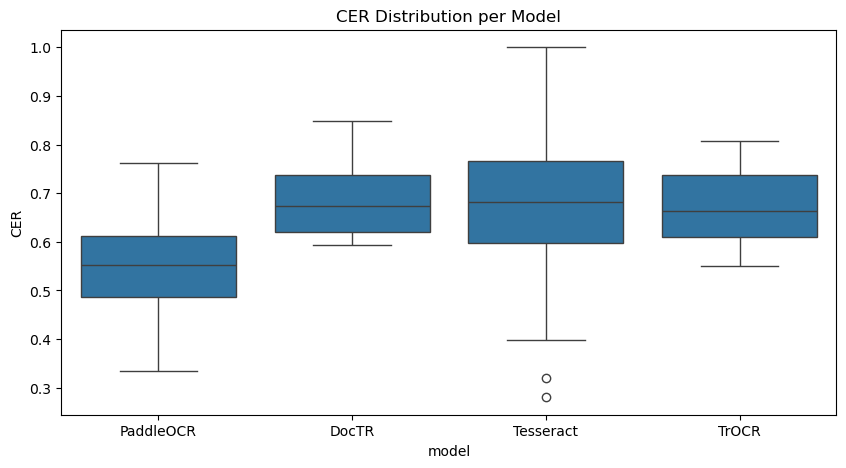

In [12]:
plt.figure(figsize=(10,5))
sns.boxplot(data=df_cer, x='model', y='CER')
plt.title("CER Distribution per Model")
plt.show()

> In terms of CER, it seems that PaddleOCR was the best performing model since its box plot, is the lowest among the 4.

## Text Length Sensitivity

In [24]:
df_merged['text_length'] = df_merged['gt_doc'].str.len()


df_cer_melt = df_merged.melt(
    id_vars=['image','text_length'],
    value_vars=['cer_paddle','cer_doc','cer_tess','cer_trocr'],
    var_name='model',
    value_name='CER'
)
df_cer_melt['model'] = df_cer_melt['model'].replace({
    'cer_paddle':'PaddleOCR',
    'cer_doc':'DocTR',
    'cer_tess':'Tesseract',
    'cer_trocr':'TrOCR'
})

df_wer_melt = df_merged.melt(
    id_vars=['image','text_length'],
    value_vars=['wer_paddle','wer_doc','wer_tess','wer_trocr'],
    var_name='model',
    value_name='WER'
)
df_wer_melt['model'] = df_wer_melt['model'].replace({
    'wer_paddle':'PaddleOCR',
    'wer_doc':'DocTR',
    'wer_tess':'Tesseract',
    'wer_trocr':'TrOCR'
})

C:\Users\Shay\AppData\Local\Temp\ipykernel_16992\3512778503.py:16: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=df_cer_melt, x='text_length', y='CER', hue='model',  palette=custom_colors, estimator='mean', ci=None)


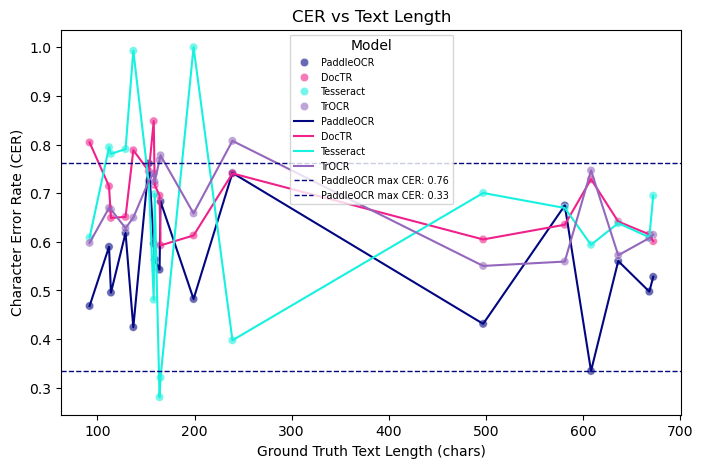

In [25]:
# Compute max CER for models
max_cer_paddle = df_cer_melt[df_cer_melt['model']=='PaddleOCR']['CER'].max()
min_cer_paddle = df_cer_melt[df_cer_melt['model']=='PaddleOCR']['CER'].min()


custom_colors = {
    "PaddleOCR": "#020680",   # blue
    "DocTR": "#ef218b",       # pink
    "Tesseract": "#17f1df",   # teal
    "TrOCR": "#9467bd"        # purple
}


plt.figure(figsize=(8,5))
sns.scatterplot(data=df_cer_melt, x='text_length', y='CER', hue='model', palette=custom_colors, alpha=0.6)
sns.lineplot(data=df_cer_melt, x='text_length', y='CER', hue='model',  palette=custom_colors, estimator='mean', ci=None)

# Add horizontal dotted line
plt.axhline(y=max_cer_paddle, color=custom_colors['PaddleOCR'], linestyle='--', linewidth=1, label=f"PaddleOCR max CER: {max_cer_paddle:.2f}")
plt.axhline(y=min_cer_paddle, color=custom_colors['PaddleOCR'], linestyle='--', linewidth=1, label=f"PaddleOCR max CER: {min_cer_paddle:.2f}")


plt.title("CER vs Text Length")
plt.xlabel("Ground Truth Text Length (chars)")
plt.ylabel("Character Error Rate (CER)")
plt.legend(title="Model", fontsize="x-small")
plt.show()

> In the line graph above, we can see that the PaddleOCR model has the most consistent performance in CER with regards to the text length of the ground truth values. It has the lowest range among all the models.

C:\Users\Shay\AppData\Local\Temp\ipykernel_16992\1708581440.py:7: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=df_wer_melt, x='text_length', y='WER', hue='model', palette=custom_colors, estimator='mean', ci=None)


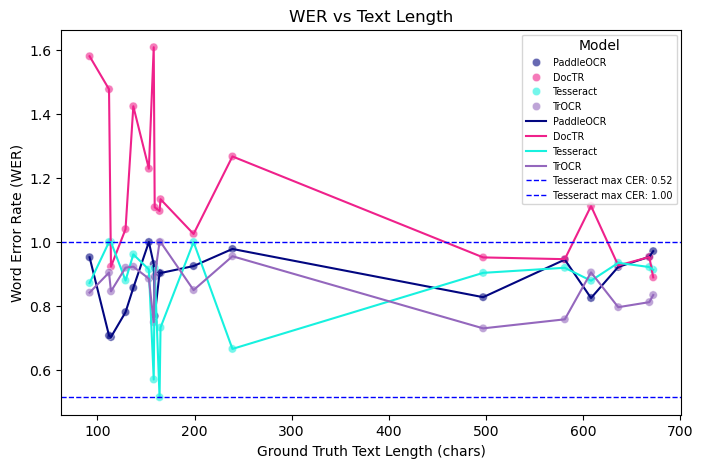

In [26]:

min_wer_tess = df_wer_melt[df_wer_melt['model']=='Tesseract']['WER'].min()
max_wer_tess = df_wer_melt[df_wer_melt['model']=='Tesseract']['WER'].max()


plt.figure(figsize=(8,5))
sns.scatterplot(data=df_wer_melt, x='text_length', y='WER', hue='model', palette=custom_colors, alpha=0.6)
sns.lineplot(data=df_wer_melt, x='text_length', y='WER', hue='model', palette=custom_colors, estimator='mean', ci=None)
plt.axhline(y=min_wer_tess, color='blue', linestyle='--', linewidth=1, label=f"Tesseract max CER: {min_wer_tess:.2f}")
plt.axhline(y=max_wer_tess, color='blue', linestyle='--', linewidth=1, label=f"Tesseract max CER: {max_wer_tess:.2f}")
plt.title("WER vs Text Length")
plt.xlabel("Ground Truth Text Length (chars)")
plt.ylabel("Word Error Rate (WER)")
plt.legend(title="Model", loc =  "upper right", fontsize="x-small")
plt.show()


> In terms of WER, the tesseract is most consistent with Word Accuracy across any character length. Tesseract may be the most consistent in WER due to the fact that it is trained on a large corpus of text.

## Common vs Rare Words

In [62]:
def freq_class(word, threshold=5.0):
    """Classify word based on real-world frequency."""
    freq = zipf_frequency(word.lower(), 'en')
    return "common" if freq >= threshold else "rare"

In [63]:
df_words = df_merged[['gt_doc','pred_paddle','pred_doc','pred_tess','pred_trocr']].copy()

df_melt = df_words.melt(
    id_vars=['gt_doc'],
    var_name='model',
    value_name='prediction'
)

df_melt['model'] = df_melt['model'].replace({
    'pred_paddle': 'PaddleOCR',
    'pred_doc': 'DocTR',
    'pred_tess': 'Tesseract',
    'pred_trocr': 'TrOCR'
})


In [64]:
records = []

for _, row in df_melt.iterrows():
    gt_tokens = str(row['gt_doc']).split()
    pred_tokens = str(row['prediction']).split()

    max_len = max(len(gt_tokens), len(pred_tokens))

    for i in range(max_len):
        gt_word = gt_tokens[i] if i < len(gt_tokens) else ""
        pred_word = pred_tokens[i] if i < len(pred_tokens) else ""

        records.append({
            'model': row['model'],
            'word': gt_word,
            'correct': int(gt_word.lower() == pred_word.lower()) if gt_word else 0,
            'freq_class': freq_class(gt_word) if gt_word else "rare"
        })

df_word_acc = pd.DataFrame(records)


In [ ]:
# Get all words from your GT text
all_gt_words = " ".join(df_merged['gt_doc']).split()

rare_words = sorted(
    set([w for w in all_gt_words if zipf_frequency(w.lower(), 'en') < 4.0])
)

print(rare_words[:50])  # print first 50 rare words


['#100', '#190', '#200', '&', '(1-2x', '(Bezam', '(Centrum', '(Centrum)', '(Ciclodin)', '(Kenzar/Arblok)', '(Lindell)', '(Neomet)', '(Normax)', '(PHAREX)', '(Provasc)', '(RITEMED)', '(RITEMED)#200', '(Urica)', '(VISTALLERG)', '(Vit', '(glitab)', '(lipiduce)', '+', '-', '/', '1000', '100mcg', '100mg', '10mg', '10mg/5mL,', '10mg/5mg', '10mg/mL', '10mg/tab', '150mcg', '160', '170', '185', '18mg', '1g', '1mg', '2-3x', '2.5', '200mg', '20mg', '250', '25mg', '2mL', '2mg', '2x', '300mg']


In [65]:
acc_summary = (
    df_word_acc
    .groupby(['model','freq_class'])['correct']
    .mean()
    .reset_index()
    .rename(columns={'correct':'accuracy'})
)


> As we can see above, Tesseract outperforms the rest of the models in terms of word-level accuracy regardless of frequency class.

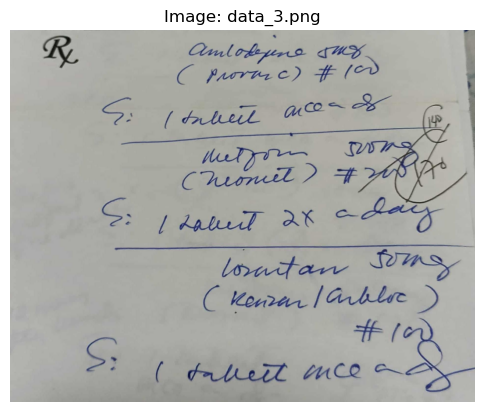

Ground Truth:
Rx Amlodipine 5mg (Provasc) #100 S: 1 tablet once a day  Metformin 500mg (Neomet) #200 S: 1 tablet 2x a day Losartan 50mg (Kenzar/Arblok) #100 S: 1 tablet once a day

PaddleOCR Model Prediction:
ennD- Pnormc) #100 acea8 Ithhel 140 uns mutgon (2eo #300 aday 2x Laluil 1 som losuitan Kensan /anblre 1 # mceo iI

DocTR Model Prediction:
Rx Ammldodian 5m0 (: Porrvacc #1 1000 S: 1 #aldcee av0o- 85 Mutfg3m 500Am5 (Nioviec 12 #x 2p 1 S: 1 Raeiee 2m a ddy L0zaatan 50mg ( Revnaaa attaa 10m S 1 ( #otdbetb OUcC Cn S 2 1 -g

Tesseract Model Prediction:
 "RR LA2mlodpine 5mg (ANovasc) #100 S: 1 tabett omnce adal Melgoin 500 mg (Neoniet) #200  S: 1 dhaet s 2x daly Lsosutamn 30mg (Renzan I Arbloc) #100 S: 1tabett omnce a a deg"

TrOCR Model Prediction:
R Shidg 500 Amdi 5 # MET # (stat) # (vas) # # S 500 Innisic 500 Bed Amdiance # S Amidine #


In [182]:
# --- Pick a sample (change index to view another row) ---
index = 0
row = df_merged.iloc[index]

image_path = Path(TEST_IMAGES_DIR) / row["image"]
gt_text = row["gt_doc"]
pred_text_paddle = row["pred_paddle"]
pred_text_doc = row["pred_doc"]
pred_text_tesseract = row["pred_tess"]
pred_text_trocr = row["pred_trocr"]

# --- Show Image ---
plt.figure(figsize=(6, 6))
plt.imshow(Image.open(image_path))
plt.axis("off")
plt.title(f"Image: {row['image']}")
plt.show()

# --- Print Text ---
print("Ground Truth:")
print(gt_text)

print("\nPaddleOCR Model Prediction:")
print(pred_text_paddle)

print("\nDocTR Model Prediction:")
print(pred_text_doc)

print("\nTesseract Model Prediction:")
print(pred_text_tesseract)

print("\nTrOCR Model Prediction:")
print(pred_text_trocr)